# Credit Account Default Status and Characteristics

Data source: https://www.kaggle.com/datasets/mishra5001/credit-card?datasetId=263888&select=columns_description.csv

Credit history matters a lot when individuals want to take out loans ... say more about this later

In [2]:
from pathlib import Path

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


import hw7_tools.plot_tools as pt

warnings.filterwarnings("ignore")

In [4]:
original_df = pd.read_csv('data/application_data.csv')

In [5]:
original_df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Data Cleaning

In [6]:
sorted_null = original_df.isnull().mean().sort_values(ascending=False)
sorted_null.index[(sorted_null>0.5)]

Index(['COMMONAREA_MEDI', 'COMMONAREA_AVG', 'COMMONAREA_MODE',
       'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAPARTMENTS_AVG',
       'NONLIVINGAPARTMENTS_MEDI', 'FONDKAPREMONT_MODE',
       'LIVINGAPARTMENTS_MODE', 'LIVINGAPARTMENTS_AVG',
       'LIVINGAPARTMENTS_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
       'FLOORSMIN_MEDI', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE',
       'YEARS_BUILD_AVG', 'OWN_CAR_AGE', 'LANDAREA_MEDI', 'LANDAREA_MODE',
       'LANDAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_AVG',
       'BASEMENTAREA_MODE', 'EXT_SOURCE_1', 'NONLIVINGAREA_MODE',
       'NONLIVINGAREA_AVG', 'NONLIVINGAREA_MEDI', 'ELEVATORS_MEDI',
       'ELEVATORS_AVG', 'ELEVATORS_MODE', 'WALLSMATERIAL_MODE',
       'APARTMENTS_MEDI', 'APARTMENTS_AVG', 'APARTMENTS_MODE',
       'ENTRANCES_MEDI', 'ENTRANCES_AVG', 'ENTRANCES_MODE', 'LIVINGAREA_AVG',
       'LIVINGAREA_MODE', 'LIVINGAREA_MEDI', 'HOUSETYPE_MODE'],
      dtype='object')

We observe that all the above columns contain more than X%(50% in our case) of nulls values, and here we make one of our major assumptions in this EDA that these data are simply unknown and can introduce bias which can affect our analysis(as opposed to them being actually informative and showing something in our data). Future work might involve taking a deeper look into these columns, but for now, with this assumption in mind, we will drop these columns together with some additional columns like ID number, which we expect to be not useful in our analysis:

In [7]:
# drop columns with more then 50% missing values + additional ones decided by the group
drop_col = ['SK_ID_CURR',]
df = original_df[sorted_null.index[(sorted_null<0.5)]].drop(drop_col, axis=1)
#sorted_col_order = list(df.columns)
#sorted_col_order.sort()
#sorted_col_order
#df = df[sorted_col_order]
# df.columns

## EDA

In the following parts of our analysis, we will identify some interesting findings in our data and attempt to build a logistic regression model to predict whether a customer will default or not. But for now, let us explore the different variables in our datasets.

First, we look at the general picture of what is the proportion of people using credit cards who are able to pay on time vs those who failed to pay on time.

### Target

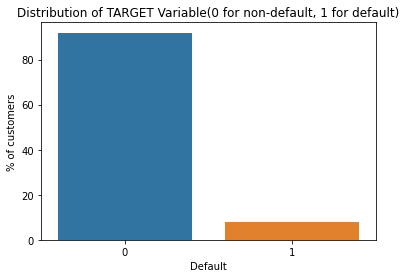

proportion of people who paid on time: 0.9192711805431351
proportion of people who failed to pay on time: 0.08072881945686496


In [8]:
sns.barplot(x="TARGET", y="TARGET", data=df, estimator=lambda x: len(x) / len(df) * 100)
plt.xlabel("Default")
plt.ylabel("% of customers")
plt.title("Distribution of TARGET Variable(0 for non-default, 1 for default)")
plt.show()
print("proportion of people who paid on time:", 1-df["TARGET"].mean())
print("proportion of people who failed to pay on time:", df["TARGET"].mean())

Notice that there the original data has a high class imbalance, so we might want to bear this fact in mind when considering the metrics to look at when evaluating classifiers later. 

## Ratio of Default vs Non-Default for different groups


We will now examine the ratio of defaulters vs non-defaulters between some other categorical variables' groups 

### Loan Type

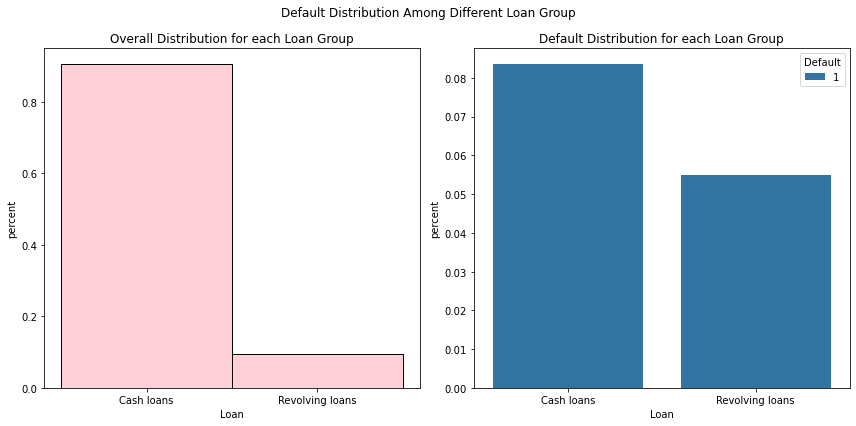

In [9]:
pt.plot_default_in_category_group('NAME_CONTRACT_TYPE', df, 'Loan')

**Observations:** 
* People who take out cash loans have a slightly higher rate of defaulting compared to revolving loans

### Gender

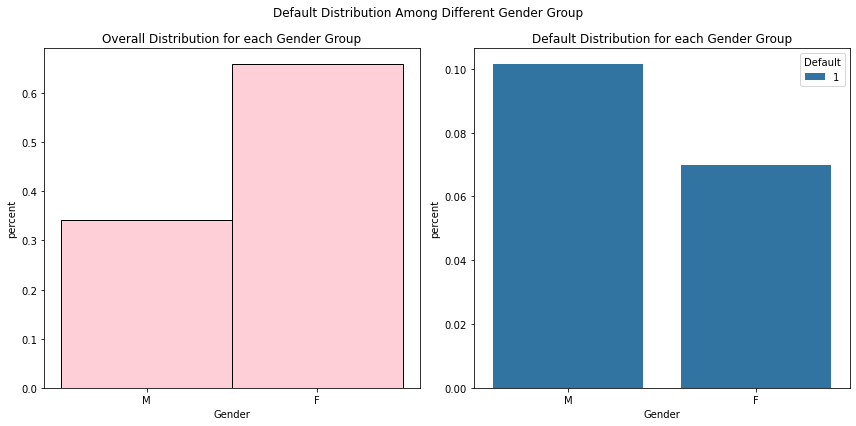

In [10]:
# omit the several XNA gender entries since we want to avoid assuming one's gender
gender_df = df[df['CODE_GENDER']!= 'XNA']
pt.plot_default_in_category_group('CODE_GENDER', gender_df, 'Gender')

**Observations:** 
* Male's seem to have a slightly higher proportion of defaults compared to female

### Income Type

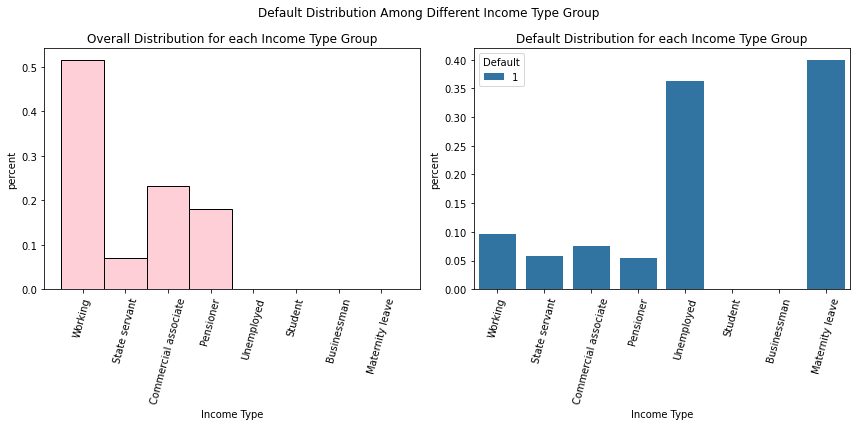

In [11]:
pt.plot_default_in_category_group('NAME_INCOME_TYPE', df, 'Income Type')

**Observations:** 
* Unemployed and Maternity leave groups seem to have a much higher proportion of default, whereas state servents and pensioners tend to have a lower proportion of defaults among them.

### Education Type

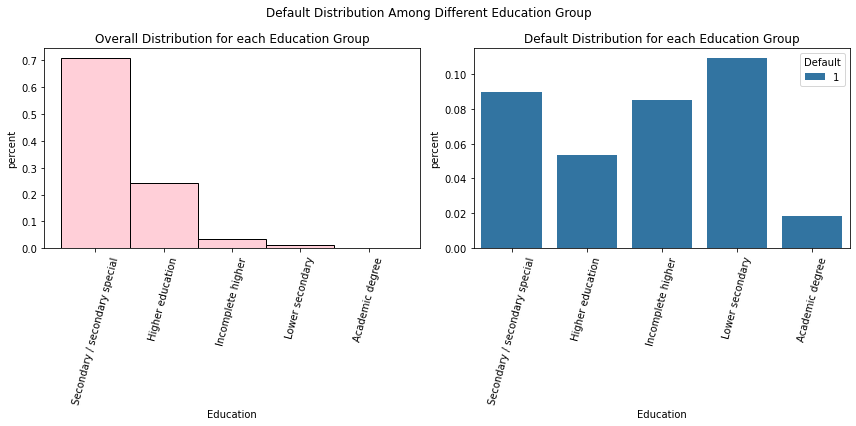

In [12]:
pt.plot_default_in_category_group('NAME_EDUCATION_TYPE', df, 'Education')

**Observations:** 
* The academic degree and higher education group have a lower proportion of defaults compared to the other groups that are slightly lower in educational degree status

### House Ownership

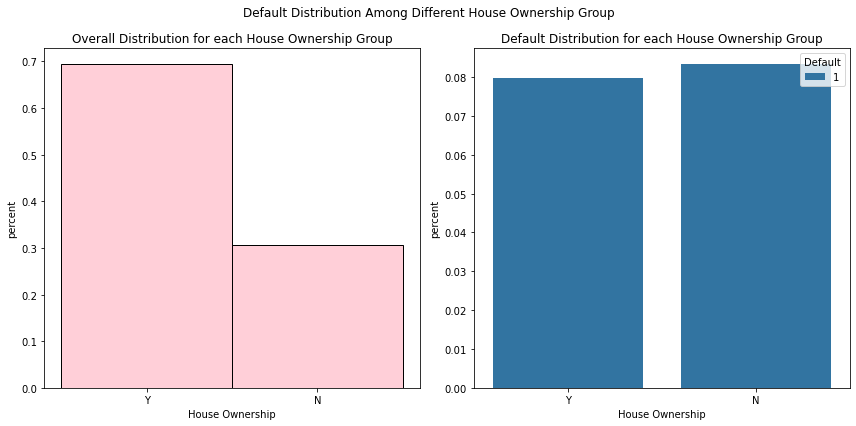

In [13]:
pt.plot_default_in_category_group('FLAG_OWN_REALTY', df, 'House Ownership')

**Observations:** 
* Whether someone owns a house or not does not change significantly the rates of defaulting on a loan

### House Type

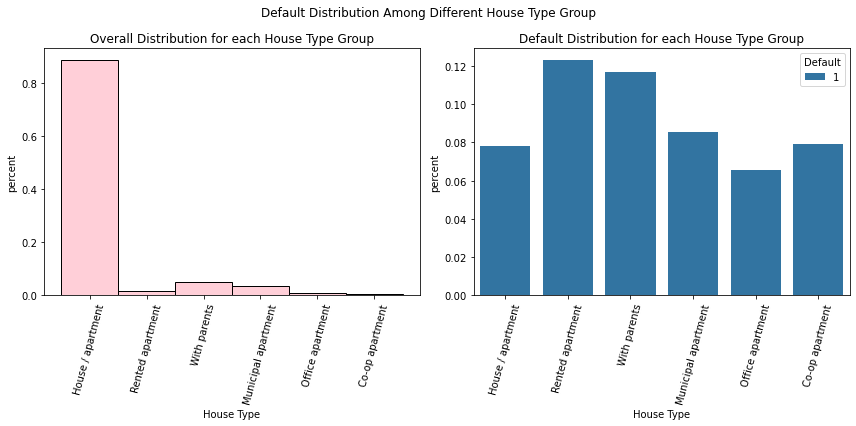

In [14]:
pt.plot_default_in_category_group('NAME_HOUSING_TYPE', df, 'House Type')

**Observations:** 
* Despite significant class imbalance where the vast majority of people have a home/apartment, the highest rates of defaulting in the house type category are those who live in a rented apartment. Higher default rates are also seen for those that live with their parents. 

### Number of Surrounding 30DPD Defaults

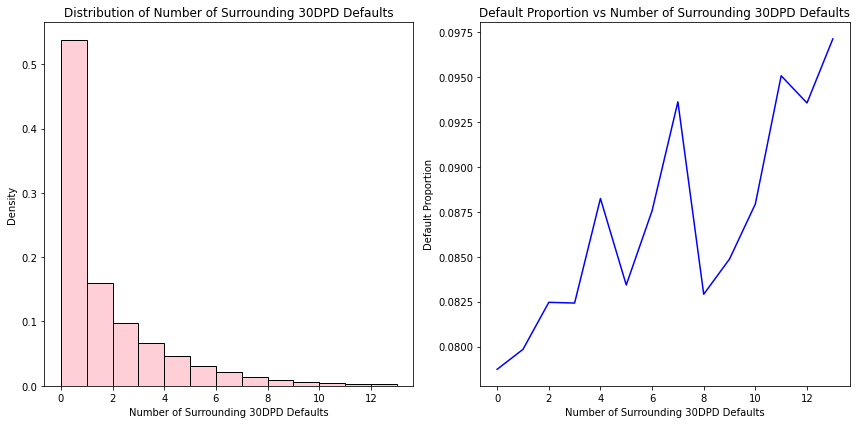

In [15]:
pt.plot_default_in_numerical_discrete_group('OBS_30_CNT_SOCIAL_CIRCLE', df, 'Number of Surrounding 30DPD Defaults')

### Number of Family Members

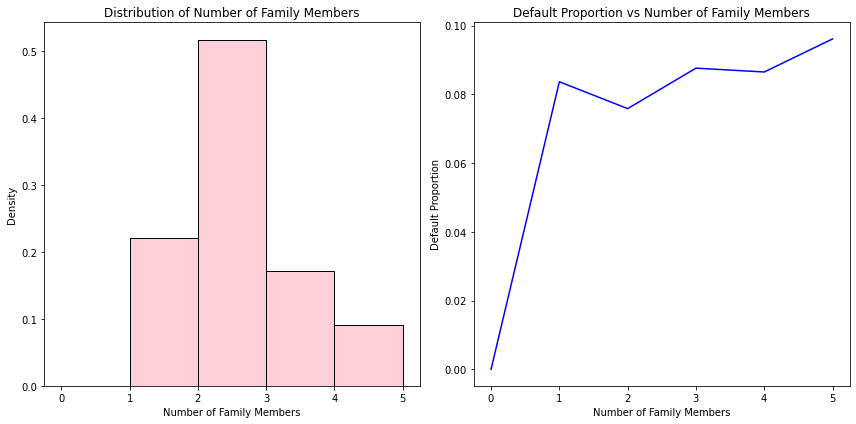

In [16]:
pt.plot_default_in_numerical_discrete_group('CNT_FAM_MEMBERS', df, 'Number of Family Members')

#### Data Takeaways

The plots above give a clear picture about the type of people within the data. The majority of people are working, female, own a home, are living in a home/apartment, and have 0 surrounding 30DPD defaults. It can also be seen that the max education for the majority of people in the data is a secondary education, which in the USA, refers to completing high school. It is interesting to see just how many people in the data own an apartment or house as it is significantly higher than for example the number of people renting. With that said, the data population really is not representative of the overall population as a whole. 

## Logistic Regression Model

The modeling section focuses on building a logistic regression model to try and predict whether someone will default on a loan or not given particular parameters from the data. As seens in the previous section, there is significant class imbalance where the vast majority of people in the data do not default on their loan. Thus metrics such as recall and precision are more important tools to determine the validity of our model compared to accuracy.

In [17]:
import sklearn.linear_model as lm

SelectedCol =['TARGET','NAME_CONTRACT_TYPE','CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
                   'FLAG_OWN_CAR','NAME_FAMILY_STATUS','OBS_30_CNT_SOCIAL_CIRCLE','CNT_FAM_MEMBERS',
                  'FLAG_OWN_REALTY']
Features = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
                   'FLAG_OWN_CAR','NAME_FAMILY_STATUS','OBS_30_CNT_SOCIAL_CIRCLE','CNT_FAM_MEMBERS',
                  'FLAG_OWN_REALTY']

In [18]:
# preprocessing gender and flag_own_car 
categorical_cols = ['FLAG_OWN_CAR', 'CODE_GENDER', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE','NAME_CONTRACT_TYPE', 'FLAG_OWN_REALTY','NAME_FAMILY_STATUS']
processed = pd.get_dummies(df[SelectedCol], columns = categorical_cols)

In [19]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(processed, test_size=0.2,random_state = 1)
train_1 = train[train['TARGET']==1].sample(10000, random_state = 1)
train_0 = train[train['TARGET']==0].sample(10000, random_state = 1)
balanced_train = pd.concat([train_1,train_0])
balanced_train_x = balanced_train[balanced_train.columns[~balanced_train.columns.isin(['TARGET'])]]
balanced_train_y = balanced_train['TARGET']
test_x = test[test.columns[~test.columns.isin(['TARGET'])]]
test_y = test['TARGET']

In [20]:
model = lm.LogisticRegression(penalty = 'none', fit_intercept = True, solver = 'lbfgs', random_state = 1)

In [21]:
model.fit(balanced_train_x, balanced_train_y)

LogisticRegression(penalty='none', random_state=1)

In [22]:
################
model.predict_proba(balanced_train_x)

array([[0.30610392, 0.69389608],
       [0.26639421, 0.73360579],
       [0.38758103, 0.61241897],
       ...,
       [0.36509282, 0.63490718],
       [0.45672734, 0.54327266],
       [0.45651262, 0.54348738]])

In [23]:
# displaying which coefficients are with which columns

coefficients = pd.DataFrame({'feature': balanced_train_x.columns, 'coeff': model.coef_[0]}, columns=['feature', 'coeff'])
coefficients.sort_values(by='coeff').head()

,feature,coeff
10,NAME_INCOME_TYPE_Pensioner,-1.048964
11,NAME_INCOME_TYPE_State servant,-1.022603
15,NAME_EDUCATION_TYPE_Academic degree,-1.019501
8,NAME_INCOME_TYPE_Commercial associate,-0.717570
7,NAME_INCOME_TYPE_Businessman,-0.626338


In [24]:
# accuracy

y_pred = model.predict(balanced_train_x)

np.mean(y_pred == balanced_train_y)

0.58465

In [25]:
from sklearn.metrics import confusion_matrix

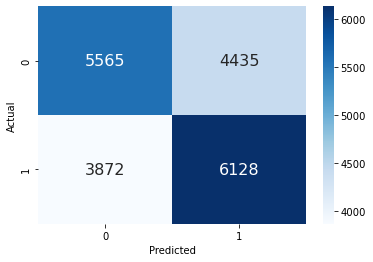

In [26]:
cm = confusion_matrix(balanced_train_y, y_pred)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [27]:
tp = np.sum((y_pred == 1) & (balanced_train_y == 1))
tn = np.sum((y_pred == 0) & (balanced_train_y == 0))
fp = np.sum((y_pred == 1) & (balanced_train_y == 0))
fn = np.sum((y_pred == 0) & (balanced_train_y == 1))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision = {precision}')
print(f'recall = {recall}')

precision = 0.5801382183091924
recall = 0.6128


### Test Results

In [115]:
y_pred = model.predict(test_x)
np.mean(y_pred == test_y)

0.5628343332845552

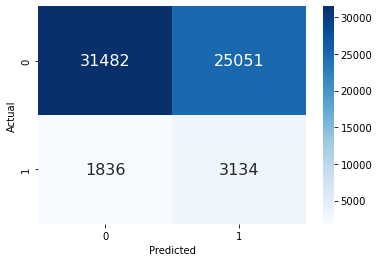

In [116]:
cm_test = confusion_matrix(test_y, y_pred)
sns.heatmap(cm_test, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [117]:
tp = np.sum((y_pred == 1) & (test_y == 1))
tn = np.sum((y_pred == 0) & (test_y == 0))
fp = np.sum((y_pred == 1) & (test_y == 0))
fn = np.sum((y_pred == 0) & (test_y == 1))
precision = tp / (tp + fp)
recall = tp / (tp + fn)
print(f'precision = {precision}')
print(f'recall = {recall}')

precision = 0.11119389746318964
recall = 0.6305835010060362


Maximizing precision will minimize the number false positives, whereas maximizing the recall will minimize the number of false negatives.

## *backup/extra code

In [32]:
# # Finding the unique values for columns with categorical variables
# unique_df = categorical_df.nunique().reset_index()
# unique_df.columns = ['Column','Number of Unique Values']

# # extract unique classes in each column
# unique_df['Unique Values'] = unique_df['Column'].apply(lambda x: df[x].unique())
# unique_df.sort_values(by='Number of Unique Values')

In [30]:
#correlation matrix 
#corr = numerical_df.corr()
#corr.style.background_gradient(cmap='coolwarm')
#corr.style.background_gradient(cmap='coolwarm').set_precision(2)
# plt.savefig('output/correlation_matrix.png') # not sure how to save this figure

In [31]:
# how target variable varies depending on contract type - does this make sense? 

# ax = sns.barplot(x="NAME_CONTRACT_TYPE", y="TARGET", data=df)
# plt.title('Target Variable Count Based on Contract Type')
# plt.savefig('output/target_contract_type_counts.png')

In [29]:
# Gender balance

# ax = sns.barplot(x=['M', 'F'], y=[sum(df['CODE_GENDER']=='M'), sum(df['CODE_GENDER']=='F')])
# plt.title('Gender Counts')
# plt.savefig('output/gender_counts.png')

In [28]:
# df['YEARS_BIRTH'] = -df['DAYS_BIRTH']/365.25
# df['YEARS_BIRTH'] = np.floor(df['YEARS_BIRTH'].copy())

# # plot the distribution of ages 

# sns.histplot(data=df, x="YEARS_BIRTH")
# plt.title('Distribution of Age')
# plt.xlabel('Age in Years')
# plt.ylabel('Freq')
# plt.savefig('output/age_counts.png')

In [39]:
#for column in numerical_df.columns:
#    plt.figure(figsize=(20,5))
#    plt.subplot(121)
#    sns.distplot(df[column])
#    plt.title(column)
#    # save figure

In [40]:
#for column in categorical_df.columns:
#    plt.figure(figsize=(30,6))
#    plt.subplot(121)
#    sns.countplot(x=df[column],hue=df['TARGET'],data=df)
#    plt.title(column)    
#    plt.xticks(rotation=90)
#    # save figures